<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [17]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [18]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import seaborn as sns          
import matplotlib.pyplot as plt             
import cv2
from PIL import Image 
import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Input,Flatten
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files as fp



In [19]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pathlib import Path
#dataset_Video=pd.read_csv('./drive/MyDrive/SampleFolderforTags/features (2).csv')
trainPathMode='./drive/MyDrive/Train/' # Training data for Separate folders with features names
testPathmode='./drive/MyDrive/Test/' # test data to evaluate the model
validatePathmode='./drive/MyDrive/Validation/' # validation data to evaluate the model during training
explicit_data='./drive/MyDrive/UnlabeledData/' # The folder has images that are not being used in train,validation,test data . 
#The explicit data are created after passing the any new video through the keyframe codes 


# Image data generator for data augmentation for train,test,validate data
# Rescaling ,Flipping,Rotating the  image data to capture its properties
trainAugment =ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.3,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
validateAugment=ImageDataGenerator(rescale=1./255)

In [20]:
valid_generator=validateAugment.flow_from_directory(
    validatePathmode,
    target_size=(299, 299),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64,
    shuffle=False,
    )

Found 523 images belonging to 2 classes.


In [21]:
train_generator=trainAugment.flow_from_directory(
    trainPathMode,
    target_size=(299, 299),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64,
    shuffle=False
    )

Found 3076 images belonging to 2 classes.


In [22]:
# Test data augmentation and generation
testAugment=ImageDataGenerator(rescale=1./255)
test_generator=testAugment.flow_from_directory(
    testPathmode,
    target_size=(299, 299),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
    )

Found 454 images belonging to 2 classes.


In [23]:
# Preparing the dataframe containing training data information
imgname=[]
fname=[]
filenames=train_generator.filenames
for i in range(len(filenames)):
  targets=filenames[i].split("/")
  imgname.append(targets[1])
  fname.append(targets[0])
trainset_details=pd.DataFrame()
trainset_details["ImageName"]=imgname
trainset_details["Feature"]=fname

In [24]:
# Features in the dataset
features_name=trainset_details["Feature"].unique()
print(features_name)

['Digital_Pen' 'Handwritten']


Image with size ( 100 X 100 )


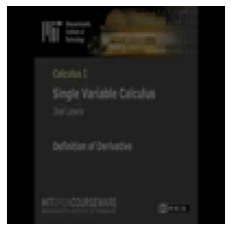

Image with size ( 150 X 150 )


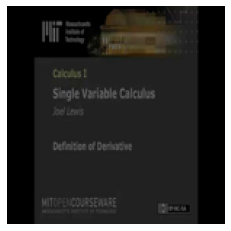

Image with size ( 200 X 200 )


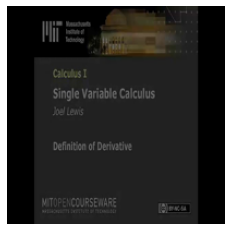

Image with size ( 224 X 224 )


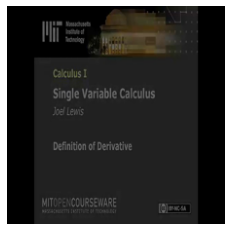

Image with size ( 256 X 256 )


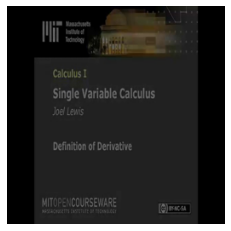

Image with size ( 299 X 299 )


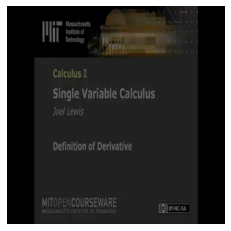

In [25]:
# sample of one data with various resizing
select_file=trainPathMode+train_generator.filenames[4]
for i in [100,150,200,224,256,299]:
    rgba_image = Image.open(select_file)
    resized=rgba_image.resize((i,i))
    print("Image with size (",i,"X",i,")")
    plt.imshow(resized)
    plt.axis("off")
    plt.show()
   

In [26]:
#Using resnet base from keras
baseModel=tf.keras.applications.InceptionV3(
    include_top=False,
     weights="imagenet",
    input_tensor=Input(shape=(299,299,3))
)

In [27]:
# 
for bl in baseModel.layers:
    bl.trainable=False

In [28]:
# Model defination for the classification
headModel=baseModel.output
headModel=MaxPooling2D(pool_size=(3,3))(headModel)
headModel=Dense(512,activation="relu")(headModel)
headModel=Dropout(rate=0.1)(headModel)
headModel=Dense(256,activation="relu")(headModel)
headModel=Dense(128,activation="relu")(headModel)
#headModel=Dense(,activation="relu")(headModel)
headModel=Flatten(name="flatten")(headModel)
headModel=Dropout(rate=0.6)(headModel)
headModel=Dense(2,activation="softmax")(headModel)

In [29]:
model=Models.Model(inputs=baseModel.input,outputs=headModel)

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [53]:
#Model compilation for training
model.compile(loss="categorical_crossentropy",optimizer=Optimizer.Adam(learning_rate=0.002),metrics=['accuracy','Precision'])

#Defining earlystopping of epoch if no improvement is found
early_stopping = EarlyStopping(monitor="val_loss",patience=6)

In [54]:
# Fitting the data into the model for training
model_history=model.fit(train_generator,steps_per_epoch=len(train_generator.filenames)//64, validation_data=valid_generator,validation_steps=len(valid_generator.filenames)//64,epochs=50,callbacks=[early_stopping])

Epoch 1/50
48/48 [==============================] - 814s 17s/step - loss: 0.9059 - accuracy: 0.8360 - precision: 0.8360 - val_loss: 0.0642 - val_accuracy: 0.9883 - val_precision: 0.9883
Epoch 2/50
48/48 [==============================] - 796s 17s/step - loss: 0.1465 - accuracy: 0.9515 - precision: 0.9515 - val_loss: 0.0399 - val_accuracy: 0.9922 - val_precision: 0.9922
Epoch 3/50
48/48 [==============================] - 801s 17s/step - loss: 0.1364 - accuracy: 0.9532 - precision: 0.9532 - val_loss: 0.1653 - val_accuracy: 0.9199 - val_precision: 0.9199
Epoch 4/50
48/48 [==============================] - 804s 17s/step - loss: 0.1359 - accuracy: 0.9499 - precision: 0.9499 - val_loss: 0.0732 - val_accuracy: 0.9785 - val_precision: 0.9785
Epoch 5/50
48/48 [==============================] - 808s 17s/step - loss: 0.0604 - accuracy: 0.9831 - precision: 0.9831 - val_loss: 0.2172 - val_accuracy: 0.8965 - val_precision: 0.8965
Epoch 6/50
48/48 [==============================] - 807s 17s/step - lo

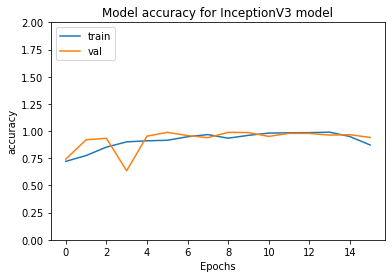

In [52]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy for InceptionV3 model')
plt.ylim(0,2)
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

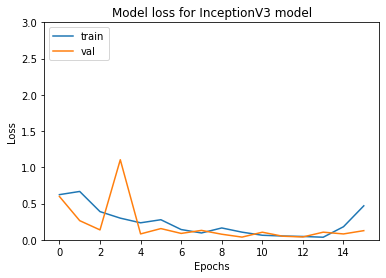

In [38]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss for InceptionV3 model')
plt.ylim(0,3)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
test_score=model.evaluate(test_generator)

15/15 [==============================] - 124s 8s/step - loss: 0.0735 - accuracy: 0.9912 - precision: 0.9912


In [40]:
scores=pd.DataFrame(zip(model.metrics_names,test_score))
print(scores) # Metrics of Test scores from Model evaluation

           0         1
0       loss  0.073526
1   accuracy  0.991189
2  precision  0.991189


In [41]:
predictions=model.predict(test_generator) # Model prediction over the test data

In [42]:
print("Total number of prediction is ", len(predictions))

Total number of prediction is  454


In [43]:
#
pred_values=[]
for i in range(len(predictions)):
  pred_values.append(features_name[np.argmax(predictions[i])])
act_values=[]
tname=[]
filenames_test=test_generator.filenames
for i in range(len(filenames_test)):
  targets=filenames_test[i].split("/")
  act_values.append(targets[0])
  tname.append(targets[1])



In [44]:
# Final prediction Dataframe
final_prediction=pd.DataFrame()
final_prediction["ImageName"]=tname
final_prediction["Actual Feature"]=act_values
final_prediction["Predicted Feature"]=pred_values


In [45]:
# Final prediction output
final_prediction.to_csv("Prediction.csv")
fp.download('Prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
# Traning data output
trainset_details.to_csv("Traning_set_info.csv")
fp.download('Traning_set_info.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
# Need to run this code if some explicit video segregation is needed
exp_images=[]
exp_data_filename=[]
for i in os.listdir(explicit_data):
     #Reading the image
     exp_data_filename.append(i)
     img =cv2.imread(explicit_data+"//"+i)
     # Normalization of images of training data 
     image = cv2.resize(img,(299,299))
     imagef=cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
     exp_images.append(imagef)

In [48]:
pred_on_exp_data=model.predict(np.array(exp_images))

In [49]:
exp_pred_values=[]
for i in range(len(pred_on_exp_data)):
  exp_pred_values.append(features_name[np.argmax(pred_on_exp_data[i])])
exp_outcome=pd.DataFrame()
exp_outcome["ImageName"]=exp_data_filename
exp_outcome["Predicted Feature"]=exp_pred_values

In [50]:
exp_outcome["Predicted Feature"].value_counts()

Digital_Pen    79
Handwritten    34
Name: Predicted Feature, dtype: int64

In [51]:
#Prediction over Unlabeled data:
# Final prediction output
exp_outcome.to_csv("Prediction_unlabeled.csv",index=False)
fp.download('Prediction_unlabeled.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>